# Rank Selection using Cophenetic Correlation

This tutorial guides you through the process of selecting the optimal NMF (and SpaHDmap) rank for your data using cophenetic correlation. Choosing an appropriate rank is crucial for obtaining meaningful and stable low-dimensional representations of your gene expression data.

We will use 10X Visium H&E stained mouse brain dataset as an example.

## 1. Import Necessary Libraries

In [2]:
import torch
import numpy as np
import scanpy as sc
import SpaHDmap as hdmap

# Install nimfa if you haven't already: pip install nimfa
try:
    import nimfa
except ImportError:
    print("Nimfa is not installed. Please install it using `pip install nimfa`.")
    nimfa = None

/home/qk/anaconda3/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


## 2. Set Parameters and Paths

Set the parameters and file paths for analysis.

In [3]:
seed = 123
scale_rate = 1
verbose = True

np.random.seed(seed)
torch.manual_seed(seed)

root_path = '../experiments/'
project = 'MPBS01'

## 3. Load data and pre-process

We will take Visium H&E stained mouse brain dataset used in previous tutorial as an example.

In [4]:
section_id = 'V1_Mouse_Brain_Sagittal_Posterior'
print(f"Downloading/loading 10X Visium H&E data for section: {section_id}")
adata = sc.datasets.visium_sge(section_id, include_hires_tiff=True)
image_path = adata.uns["spatial"][section_id]["metadata"]["source_image_path"]

# Prepare STData object
mouse_posterior = hdmap.prepare_stdata(adata=adata,
                                       section_name='mouse_posterior',
                                       image_path=image_path,
                                       scale_rate=scale_rate,
                                       swap_coord=True)

hdmap.select_svgs(mouse_posterior, n_top_genes=3000)

Downloading/loading 10X Visium H&E data for section: V1_Mouse_Brain_Sagittal_Posterior


/tmp/ipykernel_2029586/1435350002.py:3: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata = sc.datasets.visium_sge(section_id, include_hires_tiff=True)
/home/qk/anaconda3/lib/python3.11/site-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


*** Reading and preparing AnnData for section mouse_posterior ***
Spot radius found in AnnData: 45
Pre-processing gene expression data for 3355 spots and 32285 genes.
Swapping x and y coordinates.
Processing image, seems to be HE image.
Selected 3000 SVGs using moran method.


## 4. Select rank using Cophenetic Correlation

Cophenetic correlation is a metric used to evaluate the stability of clustering results across different numbers of components (ranks) in NMF. A higher cophenetic correlation value indicates a more stable and robust factorization. We typically look for the rank where the cophenetic correlation starts to plateau or shows a clear peak.

This process can be computationally intensive, as it involves running NMF multiple times for each tested rank.

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm

--- Performing NMF Rank Selection ---
This process can be time-consuming as it involves running NMF multiple times.


Testing NMF Ranks:   9%|▉         | 1/11 [04:37<46:15, 277.58s/it]

Rank 10: Cophenetic Correlation = 0.9639


Testing NMF Ranks:  18%|█▊        | 2/11 [08:35<38:09, 254.37s/it]

Rank 12: Cophenetic Correlation = 0.9612


Testing NMF Ranks:  27%|██▋       | 3/11 [13:07<34:57, 262.14s/it]

Rank 14: Cophenetic Correlation = 0.9526


Testing NMF Ranks:  36%|███▋      | 4/11 [17:35<30:53, 264.79s/it]

Rank 16: Cophenetic Correlation = 0.9423


Testing NMF Ranks:  45%|████▌     | 5/11 [21:59<26:25, 264.23s/it]

Rank 18: Cophenetic Correlation = 0.9534


Testing NMF Ranks:  55%|█████▍    | 6/11 [26:34<22:19, 267.87s/it]

Rank 20: Cophenetic Correlation = 0.9580


Testing NMF Ranks:  64%|██████▎   | 7/11 [31:19<18:13, 273.48s/it]

Rank 22: Cophenetic Correlation = 0.9455


Testing NMF Ranks:  73%|███████▎  | 8/11 [35:57<13:44, 274.95s/it]

Rank 24: Cophenetic Correlation = 0.9459


Testing NMF Ranks:  82%|████████▏ | 9/11 [39:42<08:38, 259.50s/it]

Rank 26: Cophenetic Correlation = 0.9442


Testing NMF Ranks:  91%|█████████ | 10/11 [44:29<04:27, 267.95s/it]

Rank 28: Cophenetic Correlation = 0.9375


Testing NMF Ranks: 100%|██████████| 11/11 [49:15<00:00, 268.72s/it]

Rank 30: Cophenetic Correlation = 0.9443


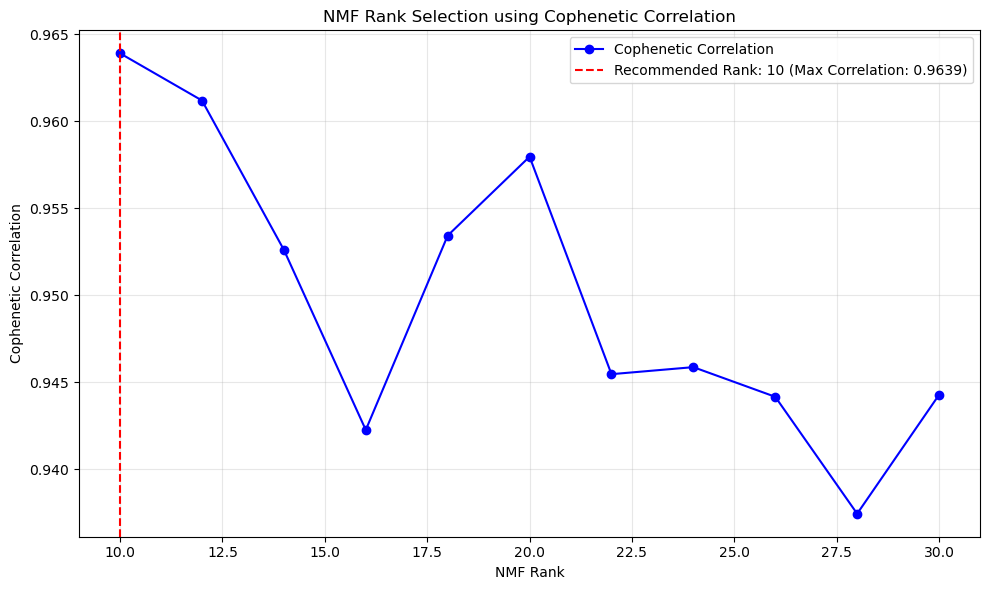

Based on cophenetic correlation, the recommended NMF rank is: 10. You can now use this rank for your SpaHDmap analysis.


In [6]:
if nimfa:
    # Define a range of ranks to test
    ranks_to_test = range(10, 31, 2) # Test ranks from 5 to 50 with step 5
    cophenetic_scores = []

    print("--- Performing NMF Rank Selection ---")
    print("This process can be time-consuming as it involves running NMF multiple times.")

    # Ensure the expression data is in a suitable format for nimfa (dense numpy array)
    # nimfa expects (n_features, n_samples) for NMF, so we transpose adata.X
    expression_matrix = mouse_posterior.adata.X.toarray().T

    for current_rank in tqdm(ranks_to_test, desc="Testing NMF Ranks"):
        # Initialize NMF model with 'nndsvd' initialization for non-negative data
        # n_run: number of times to run NMF for each rank to ensure stability
        nmf = nimfa.Nmf(expression_matrix, rank=current_rank, seed="random",
                        max_iter=200, n_run=10, track_factor=True)
        
        # Fit the NMF model
        nmf_fit = nmf()
        
        # Calculate cophenetic correlation
        coph_cor = nmf.coph_cor()
        cophenetic_scores.append(coph_cor)
        print(f"Rank {current_rank}: Cophenetic Correlation = {coph_cor:.4f}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(ranks_to_test, cophenetic_scores, 'b-o', label='Cophenetic Correlation')
    plt.xlabel('NMF Rank')
    plt.ylabel('Cophenetic Correlation')
    plt.title('NMF Rank Selection using Cophenetic Correlation')
    plt.grid(True, alpha=0.3)

    # Find and highlight the best rank (highest cophenetic correlation)
    best_idx = np.argmax(cophenetic_scores)
    best_rank = ranks_to_test[best_idx]
    plt.axvline(x=best_rank, color='r', linestyle='--',
                label=f'Recommended Rank: {best_rank} (Max Correlation: {cophenetic_scores[best_idx]:.4f})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Based on cophenetic correlation, the recommended NMF rank is: {best_rank}. You can now use this rank for your SpaHDmap analysis.")

else:
    print("NMF rank selection skipped due to missing 'nimfa' library.")
    print("Please install 'nimfa' (pip install nimfa) to enable this feature.")
    print("Proceeding with default rank (20) for demonstration purposes.")
    best_rank = 20 # Use default if nimfa is not installed

## 5. Run SpaHDmap with selected rank

After determining the optimal NMF rank, you can proceed to run the full SpaHDmap pipeline using this selected rank. This step demonstrates how to initialize the `Mapper` object with the chosen rank and prepare for the main analysis.

In [8]:
results_path = f'{root_path}/{project}/Results_Rank{best_rank}/'

# Initialize the SpaHDmap Mapper with the selected rank
mapper = hdmap.Mapper(mouse_posterior, results_path=results_path, rank=best_rank, verbose=verbose)

*** Preparing the tissue splits and creating pseudo spots... ***
*** Single section detected. Using its 3000 genes. ***
*** The split size is set to 256 pixels. ***
For section mouse_posterior, divide the tissue into 1410 sub-tissues, and create 15000 pseudo spots.
*** Using GPU ***
--- Initialized SpaHDmap Mapper with the selected rank ---
You can now run the full SpaHDmap pipeline using `mapper.run_SpaHDmap()`.


In [9]:
mapper.run_SpaHDmap(load_model=False, visualize=True)

Step 1: Run NMF
*** Performing NMF... ***
*** Visualizing and saving the embeddings of NMF... ***
Step 2: Pre-train the SpaHDmap model


/home/qk/projects/DeepFuseNMF/SpaHDmap/train.py:525: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/home/qk/projects/DeepFuseNMF/SpaHDmap/train.py:571: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Iter: 200 / 5000], Epoch: 5, Loss: 0.040226, Learning rate: 3.984269e-04
[Iter: 400 / 5000], Epoch: 9, Loss: 0.001536, Learning rate: 3.937323e-04
[Iter: 600 / 5000], Epoch: 14, Loss: 0.000827, Learning rate: 3.859904e-04
[Iter: 800 / 5000], Epoch: 18, Loss: 0.000574, Learning rate: 3.753232e-04
[Iter: 1000 / 5000], Epoch: 23, Loss: 0.000476, Learning rate: 3.618989e-04
[Iter: 1200 / 5000], Epoch: 27, Loss: 0.000360, Learning rate: 3.459292e-04
[Iter: 1400 / 5000], Epoch: 32, Loss: 0.000328, Learning rate: 3.276661e-04
[Iter: 1600 / 5000], Epoch: 36, Loss: 0.000277, Learning rate: 3.073974e-04
[Iter: 1800 / 5000], Epoch: 40, Loss: 0.000260, Learning rate: 2.854430e-04
[Iter: 2000 / 5000], Epoch: 45, Loss: 0.000223, Learning rate: 2.621489e-04
[Iter: 2200 / 5000], Epoch: 49, Loss: 0.000200, Learning rate: 2.378826e-04
[Iter: 2400 / 5000], Epoch: 54, Loss: 0.000186, Learning rate: 2.130267e-04
[Iter: 2600 / 5000], Epoch: 58, Loss: 0.000172, Learning rate: 1.879733e-04
[Iter: 2800 / 5000

*** Visualizing and saving the embeddings of SpaHDmap... ***


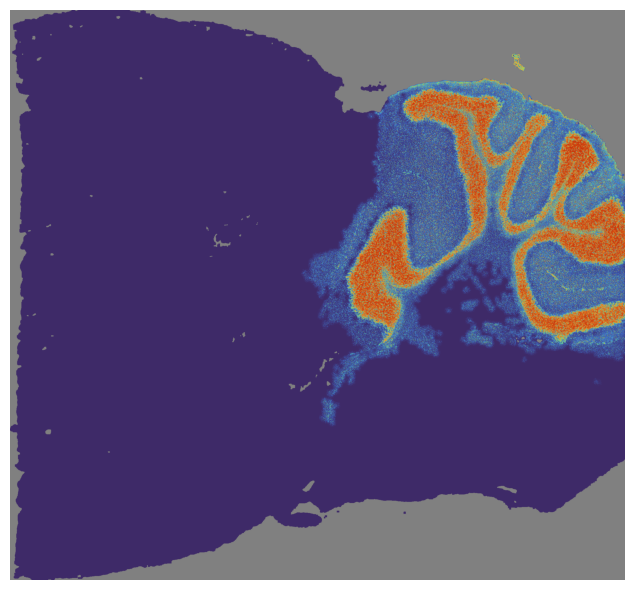

In [11]:
mapper.visualize(index=2, use_score='SpaHDmap')